Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import mysql.connector
from sklearn import tree
import joblib

Database Connection

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="user",
    password="password",
    port="3306",
    database="realestatepredictor"
)

Prepare data

In [3]:
# Create a cursor object
cursor = db.cursor()

# Execute the query
cursor.execute("SELECT * FROM homegate")

# Fetch all the records
data = cursor.fetchall()

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['id', 'homegateid', 'price', 'rooms', 'floor', 'livingSpace', 'street', 'latitude', 'longitude', 'locality', 'postalcode'])

# Close the cursor and connection
cursor.close()
db.close()

# Handle null / empty values
df = df.dropna(subset=['price', 'rooms', 'livingSpace', "latitude", "longitude", "postalcode"])

# Remove values 0 from the price and livingSpace columns
df = df[df.price != 0]
df = df[df.livingSpace != 0]

# Define a function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1
    df_final = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df_final

# Remove outliers from 'price', 'floor' and 'livingSpace'
df = remove_outliers(df, 'price')
df = remove_outliers(df, 'floor')
df = remove_outliers(df, 'livingSpace')

Random Forest, finding Hyperparameters automatically

In [4]:
# Prepare the data for the random forest
X = df[['rooms', 'floor', 'livingSpace', 'latitude', 'longitude', 'postalcode']]
y = df['price']

# Save column names before standardization
feature_names = X.columns

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest
rf = RandomForestRegressor(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [10, 20, 40, 60, 80, 100, 150, 200, 400, 600, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Train the model using the grid search estimator. 
# This will take the random forest model and try each combination of parameters
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1320 candidates, totalling 3960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             verbose=2)

Random Forest stats

Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Root Mean Squared Error: 340280.570229802
Average depth: 20.0
Average number of nodes: 3366.22
Mean Absolute Error: 195680.137549149
Mean Absolute Percentage Error: 17.121377275659377%
Accuracy: 82.87862272434063%


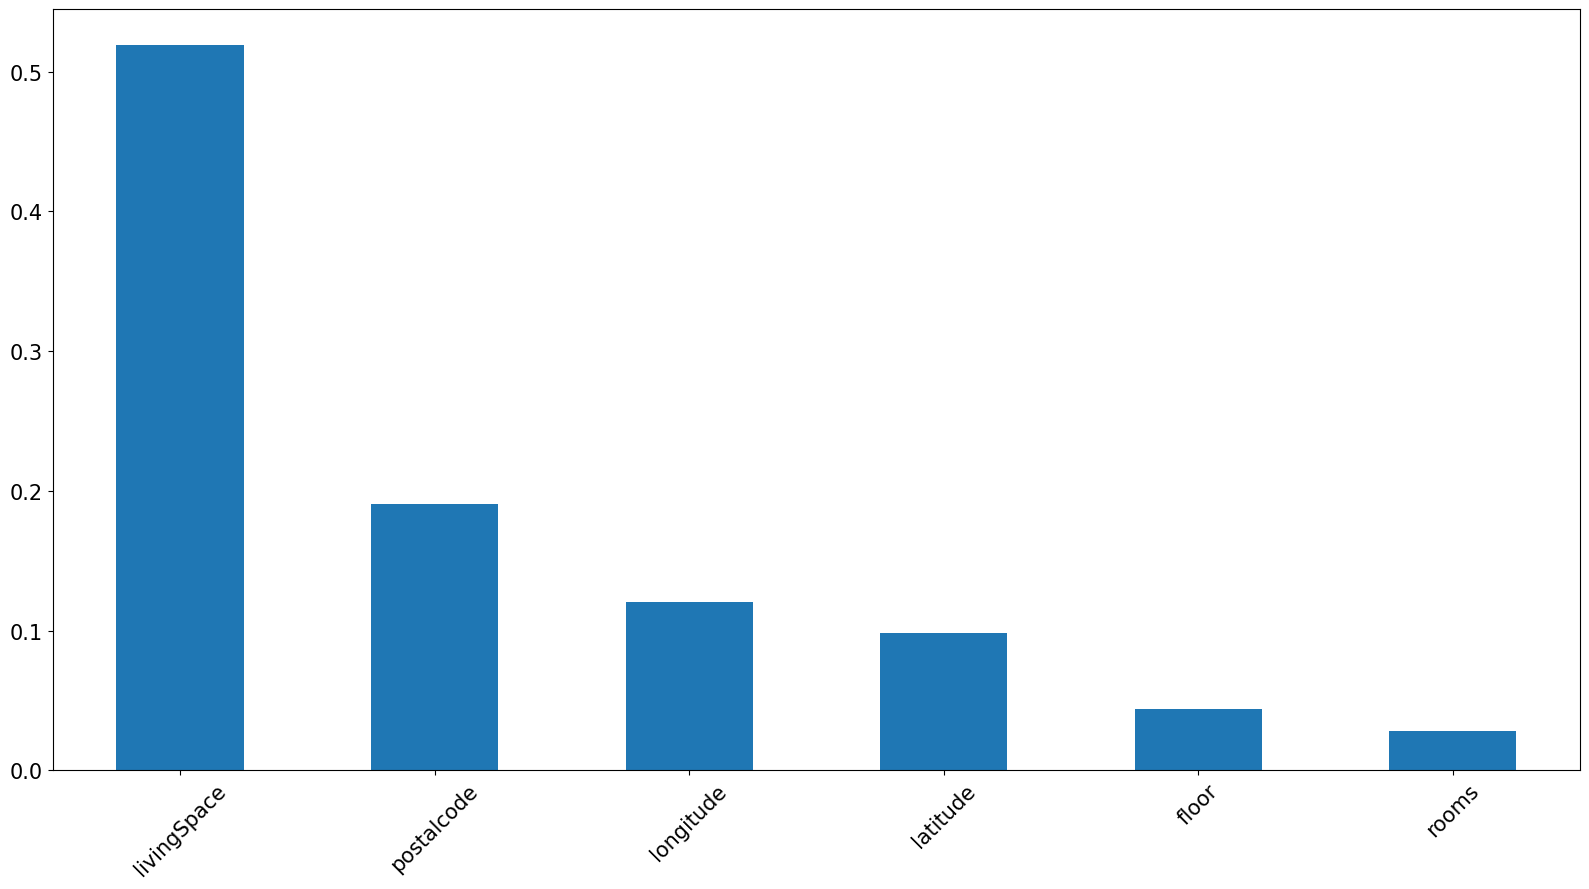

In [5]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Make predictions using the model with the best parameters
y_pred = grid_search.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 800)
# tree.plot_tree(grid_search.best_estimator_.estimators_[0], feature_names = feature_names, filled = True)
# fig.savefig('rf_individualtree.png')

# Get the best estimator
best_rf = grid_search.best_estimator_

# Get the depth of each decision tree
depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
print(f"Average depth: {np.mean(depths)}")

# Get the number of nodes of each decision tree
num_nodes = [estimator.tree_.node_count for estimator in best_rf.estimators_]
print(f"Average number of nodes: {np.mean(num_nodes)}")

# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Calculate mean absolute error (MAE)
mae = np.mean(errors)
print(f"Mean Absolute Error: {mae}")

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
mean_mape = np.mean(mape)
print(f"Mean Absolute Percentage Error: {mean_mape}%")

# Determine the performance metrics
accuracy = 100 - mean_mape
print(f"Accuracy: {accuracy}%")

# Get feature importances
importances = grid_search.best_estimator_.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, feature_names)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()

Save model

In [6]:
joblib.dump(grid_search, "randomforest.joblib", compress=3)
joblib.dump(scaler, "scaler.joblib", compress=3)
joblib.dump(feature_names, "feature_names.joblib", compress=3)

['feature_names.joblib']